In [416]:
import eval7

import random


Card = eval7.Card
Hand = tuple[Card, ...]


def _draw(community: tuple[Card, ...], cards: list[Card]):
    i = 0  # typing

    for i in range(len(cards)):
        j = random.randint(1 + i, len(cards) - 1)
        cards[i], cards[j] = cards[j], cards[i]

        if (i >= 1 and len(community) > 0) or i > 1:
            last = community[-1] if i == 1 else cards[i]
            if len(community) + i - 1 >= 5 and last.suit not in (1, 2):
                break

    return tuple(cards[:2]), community + tuple(cards[2:i + 1])


def hs(hand: tuple[Card, Card], community: tuple[Card, ...], maxiter: int):
    cards = [
        card for card in eval7.Deck().cards
        if card not in hand and card not in community
    ]

    sco = 0
    for _ in range(maxiter):
        other, completion = _draw(community, cards)
        us = eval7.evaluate(hand + completion)
        op = eval7.evaluate(other + completion)
        sco += 2 if us > op else 1 if us == op else 0

    return sco / (2 * maxiter)

In [638]:
%timeit hs((Card('Ad'), Card('Kh')), (Card('Ac'),), 30)

303 µs ± 3.81 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [422]:
%timeit hs((Card('Ad'), Card('Kh')), (Card('Ac'),), 30)

302 µs ± 763 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [433]:
import numpy as np

from itertools import combinations


def hands(k=2):
    return combinations(eval7.Deck().cards, k)


def equity(hand: tuple[Card, Card], community: tuple[Card, ...], d: int, maxiter: int):
    cards = [
        card for card in eval7.Deck().cards
        if card not in hand and card not in community
    ]

    dist = []
    for _ in range(maxiter):
        _, completion = _draw(community, cards)
        strength = hs(hand, completion, 30)
        dist.append(strength)
    
    hist, _ = np.histogram(dist, bins=d, range=(0, 1))
    return hist / hist.sum()

In [424]:
from tqdm import tqdm

In [434]:
D = 15

profiles = {}
for hand in tqdm(hands()):
    profiles[hand] = equity(hand, (), D, 50)

1326it [00:15, 87.39it/s]


In [435]:
import matplotlib.pyplot as plt
import ot

In [436]:
from numba import njit


@njit
def emd(h1: list[float], h2: list[float]) -> float:
    d = 0

    carry = 0
    for v1, v2 in zip(h1, h2):
        d += abs(carry)
        carry = v1 + carry - v2

    return d

<BarContainer object of 15 artists>

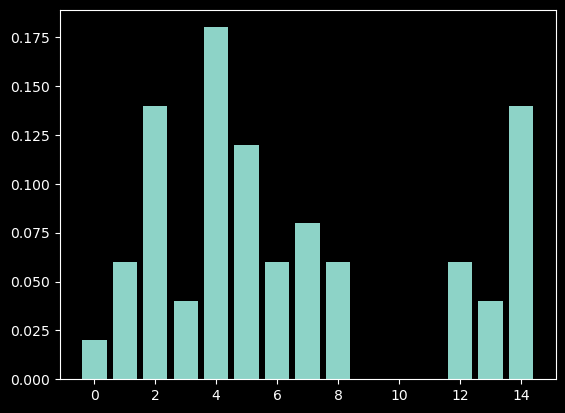

In [438]:
plt.bar(range(D), profiles[next(hands())])

In [439]:
dists = np.empty((1326, 1326), dtype=float)

for i, h1 in tqdm(enumerate(profiles.values())):
    for j, h2 in enumerate(profiles.values()):
        dists[i, j] = emd(h1, h2)

1326it [00:01, 1107.42it/s]


In [593]:
import numpy.typing as npt


def kmeanspp(vecs: npt.NDArray[np.float64], k: int):
    centroids = []
    for _ in range(k):
        mi, md = 0, 0
        for i in np.random.choice(len(vecs), k, replace=False):
            if len(centroids) == 0:
                mi = i
                break

            ix = np.random.choice(len(centroids), min(len(centroids), 10))
            d = min(emd(vecs[i], centroids[c]) for c in ix)
            if d > md:
                mi, md = i, d
        centroids.append(vecs[mi])
    
    return np.asarray(centroids)

@njit
def _pdist(vecs: npt.NDArray[np.float64], centroids: npt.NDArray[np.float64]):
    k, d = centroids.shape
    n, _ = vecs.shape

    dists = np.empty((n, k))
    for i in range(n):
        for j in range(k):
            dists[i, j] = emd(centroids[j], vecs[i])

    return dists


def _labels(vecs: npt.NDArray[np.float64], centroids: npt.NDArray[np.float64]):
    dists = _pdist(vecs, centroids)
    return np.argmin(dists, axis=1)


def kmeans(vecs: npt.NDArray[np.float64], centroids: npt.NDArray[np.float64], maxiter: int):
    k, d = centroids.shape

    for _ in range(maxiter):
        labels = _labels(vecs, centroids)
        for j in range(k):
            members = vecs[labels == j]
            if len(members):
                centroids[j] = members.mean(axis=0)

    return centroids, _labels(vecs, centroids)

In [594]:
dat = np.vstack(list(profiles.values()))
centroids = kmeanspp(dat, 100)

In [597]:
centroids, labels = kmeans(dat, centroids, 100)

In [477]:
cards = eval7.Deck().cards

flprofs = {}
for _ in tqdm(range(10000)):
    flop = tuple(random.sample(cards, 6))
    hand, comm = flop[:2], flop[2:]
    flprofs[flop] = equity(hand, comm, D, 50)

100%|██████████| 10000/10000 [01:51<00:00, 89.57it/s]


In [599]:
dat = np.vstack(list(flprofs.values()))
centroids = kmeanspp(dat, 500)
centroids, labels = kmeans(dat, centroids, 20)

5907it [00:19, 296.81it/s]


<AxesSubplot: >

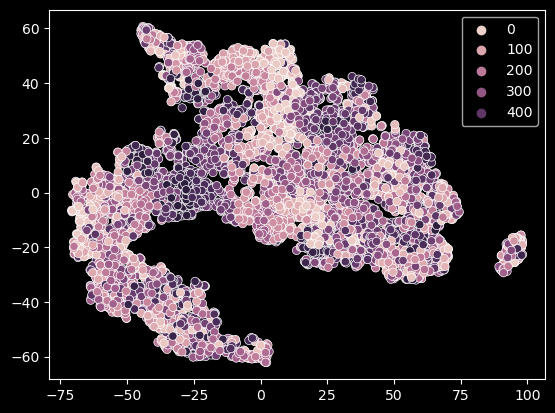

In [600]:
fldists = np.empty((len(flprofs), len(flprofs)), dtype=float)
for i, h1 in tqdm(enumerate(flprofs.values())):
    for j, h2 in enumerate(flprofs.values()):
        fldists[i, j] = emd(h1, h2)

flvecs = TSNE(init="random", metric="precomputed").fit_transform(fldists)
sns.scatterplot(x=flvecs[:, 0], y=flvecs[:, 1], hue=labels)

In [608]:
@njit
def closest(vec, vecs):
    mj, md = 0, np.inf
    for j, v in enumerate(vecs):
        d = emd(vec, v)
        if d < md:
            mj, md = j, d
    return mj, md

In [616]:
h = next(iter(flprofs))
flp = flprofs[h]
%timeit closest(flp, centroids)

8.49 µs ± 5.71 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [620]:
cards = eval7.Deck().cards

tuprofs = {}
for _ in tqdm(range(10000)):
    turn = tuple(random.sample(cards, 6))
    hand, comm = turn[:2], turn[2:]
    tuprofs[turn] = equity(hand, comm, D, 50)

100%|██████████| 10000/10000 [01:52<00:00, 89.24it/s]


In [621]:
dat = np.vstack(list(tuprofs.values()))
centroids = kmeanspp(dat, 500)
centroids, labels = kmeans(dat, centroids, 20)

10000it [00:58, 170.36it/s]


<AxesSubplot: >

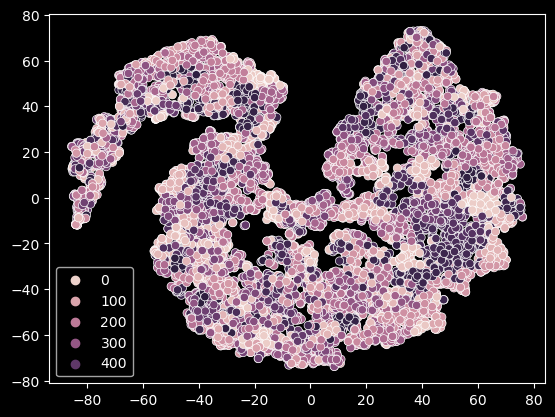

In [622]:
tudists = np.empty((len(tuprofs), len(tuprofs)), dtype=float)
for i, h1 in tqdm(enumerate(tuprofs.values())):
    for j, h2 in enumerate(tuprofs.values()):
        tudists[i, j] = emd(h1, h2)

tuvecs = TSNE(init="random", metric="precomputed").fit_transform(tudists)
sns.scatterplot(x=tuvecs[:, 0], y=tuvecs[:, 1], hue=labels)